In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wine-quality-dataset/WineQT.csv


In [ ]:
# The above code is for loading the wine quality dataset from kaggle but can be run locally as well

# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [3]:
# For Kaggle
# dataset = pd.read_csv('../input/wine-quality-dataset/WineQT.csv')

dataset = pd.read_csv('WineQT.csv')
dataset.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,6
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,8
9,6.7,0.58,0.08,1.8,0.097,15.0,65.0,0.9959,3.28,0.54,9.2,5,10


The indepedent variables (features) are the columns **fixed acidity**, **volatile acidity**,... right upto column **alcohol**  

Column **Id** needs to be dropped as its value is the index in this dataset.  

The dependent variable is column **quality**, which our model will be trained to predict.

In [4]:
dataset.drop(['Id'], axis = 1, inplace = True)

# Check if dataset has null values

In [5]:
dataset.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

# Feature Correlation Check

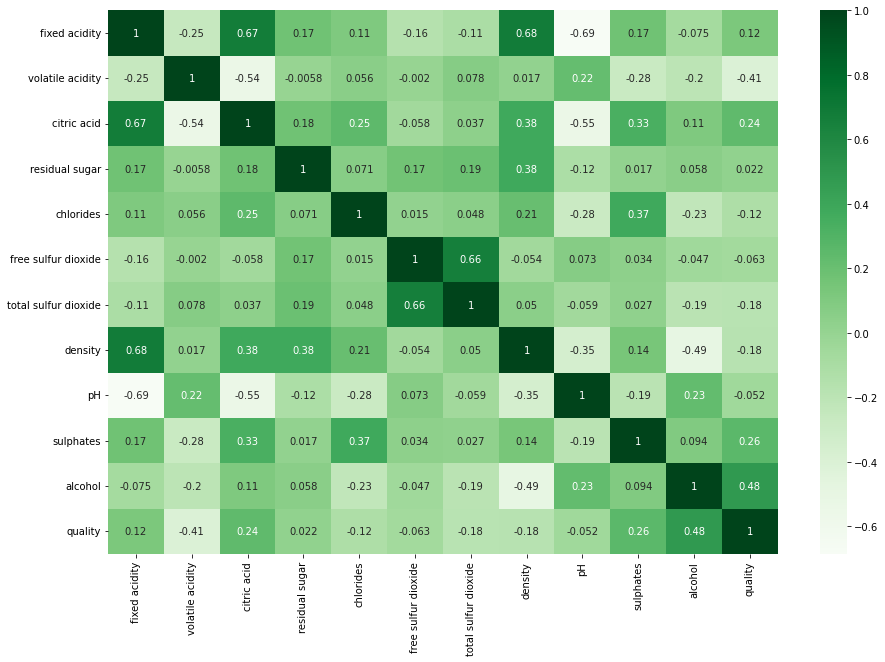

In [6]:
import seaborn as sns

plt.figure(figsize=[15, 10])
sns.heatmap(dataset.corr(), annot = True, cmap = 'Greens')

plt.show()

In [7]:
print((dataset.corr()['quality']*100).sort_values(ascending=False))

quality                 100.000000
alcohol                  48.486621
sulphates                25.771026
citric acid              24.082084
fixed acidity            12.197010
residual sugar            2.200193
pH                       -5.245303
free sulfur dioxide      -6.325964
chlorides               -12.408453
density                 -17.520792
total sulfur dioxide    -18.333915
volatile acidity        -40.739351
Name: quality, dtype: float64


Features **residual sugar**, **pH** and **free sulfur dioxide** have a lower correlation with quality than other features  

Currently won't drop them, as I will train the model with & without these features to see the difference in perfomance.  

# Check value distribution of output classes

In [8]:
dataset['quality'].value_counts()

5    483
6    462
7    143
4     33
8     16
3      6
Name: quality, dtype: int64

This seems to be a case of an imbalanced dataset, we can use SMOTE oversampling technique to increase the number of minority classes present in the dataset   
**quality** values : 3, 4, 7, 8, are the minority classes in this dataset

# Splitting Dependent and Independent Variables

In [9]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# X = dataset.drop(['residual sugar', 'pH', 'free sulfur dioxide',], axis = 1).iloc[:, :-1].values
# y = dataset.drop(['residual sugar', 'pH', 'free sulfur dioxide',], axis = 1).iloc[:, -1].values

# SMOTE Oversampling  
> Trying out two different sampling strategies
> 1. Sampling all minority classes to the total number of entries present in the majority class  
> (Quality : 5, has 483 entries. Hence all other classes will be oversampled to get total entries of 483 in each class)  
> 
> 2. Sampling minority classes to a specific number. In this way, I can control the total number of oversampled entries in the minority classes

In [10]:
# Strategy 1
oversample_strat1 = SMOTE()
X_strat1, y_strat1 = oversample_strat1.fit_resample(X, y)

# Strategy 2
sampling_strat = {3: 150, 4: 350, 7: 400, 8: 320}
oversample_strat2 = SMOTE(sampling_strategy = sampling_strat)
X_strat2, y_strat2 = oversample_strat2.fit_resample(X, y)

# Create Classification Model using RandomForestClassifier

In [11]:
def createModel(X_strat, y_strat):
    X_train, X_test, y_train, y_test = train_test_split(X_strat, y_strat, test_size = 0.2, random_state = 0)

    scale = StandardScaler()

    X_train = scale.fit_transform(X_train)
    X_test = scale.transform(X_test)

    classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 69, max_features = 'auto')

    classifier.fit(X_train, y_train)
    
    return(classifier, X_train, X_test, y_train, y_test)

# Create Confusion Matrix and Check stats using CrossValScore and GridSearch

In [12]:
def dispXScore(classifier, X_train, y_train, y_test):
    y_pred = classifier.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print('Train Set Accuracy : ', accuracy_score(y_train, classifier.predict(X_train))*100)
    print('Test Set Accuracy  : ', accuracy_score(y_test, y_pred)*100)
    print('Precision          : ', precision_score(y_test, y_pred, average = 'micro')*100)
    print('F1 Score           : ', f1_score(y_test, y_pred, average = 'micro')*100)
    print('Recall Score       : ', recall_score(y_test, y_pred, average = 'micro')*100)

    performance = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 5)
    print(' ')
    print('Cross Validation Stats')
    print('Best Accuracy      : ', performance.mean()*100)
    print('Best Std Deviation : ', performance.std()*100)

In [13]:
def dispGridSearch(classifier, X_train, y_train):
    parameters = [{'n_estimators' : [i for i in range(50, 201, 20)], 'criterion' : ['gini', 'entropy'],
                   'max_features' : ['auto', 'sqrt', 'log2']}]

    grid_search = GridSearchCV(estimator = classifier, param_grid = parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)
    grid_search.fit(X_train, y_train)
    
    print(' ')
    print('Grid Search Stats')
    print('Best Accuracy      : ', grid_search.best_score_*100)
    print('Best Params        : ', grid_search.best_params_)

# All Columns and SMOTE Strategy 1

In [14]:
classifier, X_train, X_test, y_train, y_test = createModel(X_strat1, y_strat1)
dispXScore(classifier, X_train, y_train, y_test)
dispGridSearch(classifier, X_train, y_train)

[[99  0  0  0  0  0]
 [ 0 79  0  0  0  0]
 [ 0  8 69 20  2  0]
 [ 0  5 24 52 20  2]
 [ 0  0  1  7 98  2]
 [ 0  0  0  1  1 90]]
Train Set Accuracy :  100.0
Test Set Accuracy  :  83.9655172413793
Precision          :  83.9655172413793
F1 Score           :  83.96551724137929
Recall Score       :  83.9655172413793
 
Cross Validation Stats
Best Accuracy      :  84.3838906680569
Best Std Deviation :  1.3993007922611795
 
Grid Search Stats
Best Accuracy      :  84.81492515081553
Best Params        :  {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 150}


# All Columns and SMOTE Strategy 2

In [15]:
classifier, X_train, X_test, y_train, y_test = createModel(X_strat2, y_strat2)
dispXScore(classifier, X_train, y_train, y_test)
dispGridSearch(classifier, X_train, y_train)

[[24  0  0  0  0  0]
 [ 0 62  4  2  0  0]
 [ 1  3 80 17  2  0]
 [ 0  2 24 50 14  4]
 [ 0  0  0  5 74  3]
 [ 0  0  0  0  2 60]]
Train Set Accuracy :  100.0
Test Set Accuracy  :  80.83140877598153
Precision          :  80.83140877598153
F1 Score           :  80.83140877598153
Recall Score       :  80.83140877598153
 
Cross Validation Stats
Best Accuracy      :  77.94522829871234
Best Std Deviation :  2.26600745606824
 
Grid Search Stats
Best Accuracy      :  79.0992986956739
Best Params        :  {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 110}


# Drop columns having less correlation with output variable

In [16]:
X = dataset.drop(['residual sugar', 'pH', 'free sulfur dioxide',], axis = 1).iloc[:, :-1].values
y = dataset.drop(['residual sugar', 'pH', 'free sulfur dioxide',], axis = 1).iloc[:, -1].values

# Strategy 1
oversample_strat1 = SMOTE()
X_strat1, y_strat1 = oversample_strat1.fit_resample(X, y)

# Strategy 2
sampling_strat = {3: 150, 4: 350, 7: 400, 8: 320}
oversample_strat2 = SMOTE(sampling_strategy = sampling_strat)
X_strat2, y_strat2 = oversample_strat2.fit_resample(X, y)

# Drop Columns 'residual sugar, pH and free sulfur dioxide' and SMOTE Strategy 1

In [17]:
classifier, X_train, X_test, y_train, y_test = createModel(X_strat1, y_strat1)
dispXScore(classifier, X_train, y_train, y_test)
dispGridSearch(classifier, X_train, y_train)

[[ 99   0   0   0   0   0]
 [  0  77   1   1   0   0]
 [  0   6  70  20   3   0]
 [  0   5  20  49  27   2]
 [  0   0   1   2 103   2]
 [  0   0   0   0   3  89]]
Train Set Accuracy :  100.0
Test Set Accuracy  :  83.9655172413793
Precision          :  83.9655172413793
F1 Score           :  83.96551724137929
Recall Score       :  83.9655172413793
 
Cross Validation Stats
Best Accuracy      :  82.3130632308036
Best Std Deviation :  1.7223552011890864
 
Grid Search Stats
Best Accuracy      :  82.5287666641841
Best Params        :  {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 110}


# Drop Columns 'residual sugar, pH and free sulfur dioxide' and SMOTE Strategy 2

In [18]:
classifier, X_train, X_test, y_train, y_test = createModel(X_strat2, y_strat2)
dispXScore(classifier, X_train, y_train, y_test)
dispGridSearch(classifier, X_train, y_train)

[[24  0  0  0  0  0]
 [ 0 59  6  2  1  0]
 [ 2  4 82 12  3  0]
 [ 0  4 26 49 13  2]
 [ 0  0  0 12 70  0]
 [ 0  0  0  0  1 61]]
Train Set Accuracy :  100.0
Test Set Accuracy  :  79.67667436489607
Precision          :  79.67667436489607
F1 Score           :  79.67667436489607
Recall Score       :  79.67667436489607
 
Cross Validation Stats
Best Accuracy      :  77.36669387483136
Best Std Deviation :  1.1156349385742887
 
Grid Search Stats
Best Accuracy      :  78.06016891272843
Best Params        :  {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 170}


# Conclusion
  **SMOTE Sampling Strategy 1** - Sampling all minority classes to the total number of entries present in the majority class  
  
  **SMOTE Sampling Strategy 2** - Sampling minority classes to a specific number, controlling the total number of oversampled entries in the minority classes  
      
    
    
  
   Using all **11** features in that dataset to create our classification model
  
- Comparing SMOTE Strategy 1 & 2, we get a higher accuracy using Strat 1


  There are **11** features in that dataset, after dropping '**residual sugar**, **pH** and **free sulfur dioxide**', leaving only **8** featuers to create our classification model
- Comparing SMOTE Strategy 1 & 2, we get a higher accuracy using Strat 1
  
  <br/>
As expected, removing these 3 features didn't result in a significant decrease in accuracy.
  <br/>
  
    

  The training set accuracy has an accuracy of 100%, there seems to be a case of overfitting. I would love some suggestions on how to regularize this dataset and any other techniques that could be incoporated that could make this model function better.  
  Thank you in advance!
      